# Exploratory Data Analysis

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import Data Set

In [22]:
features_df = pd.read_csv('../data/raw/X_train.csv')
target_df = pd.read_csv('../data/raw/y_train.csv')
df = features_df.set_index('id').join(target_df.set_index('id'))

In [23]:
df.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Label encoding target column
Create column to hold numerical representation of the target column

In [156]:
df['status_group'] = df['status_group'].astype('category')

In [157]:
df['target'] = df['status_group'].cat.codes

In [159]:
df.sample(1)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,geometry,target
id,,,,,,,,,,,,,,,,,,,,,
32088,200.0,2013-01-18,World Bank,633,D$L,39.276635,-10.15214,Kwa Chiputa,0,Ruvuma / Southern Coast,...,insufficient,insufficient,river,river/lake,surface,communal standpipe multiple,communal standpipe,non functional,POINT (39.27664 -10.15214),2


### Which water sources tend to be more functional

In [144]:
df['status_group'].unique().tolist()

['functional', 'non functional', 'functional needs repair']

In [142]:
columns = ['source'] + [ title.replace(' ', '_') for title in df['status_group'].unique().tolist() ] 
water_sources_df = pd.DataFrame(columns=columns)
for source in df['source'].unique().tolist():
    counts = df[df['source'] == source]['status_group'].value_counts(normalize=True)
    row = { columns[0]: source, columns[1]: counts['functional'], columns[2]: counts['non functional'], columns[3]: counts['functional needs repair']}
    water_sources_df = water_sources_df.append(row, ignore_index=True)

In [143]:
water_sources_df.sort_values(columns[2], ascending=False)

,source,functional,non_functional,functional_needs_repair
8,lake,0.211765,0.772549,0.015686
2,dam,0.385671,0.577744,0.036585
3,machine dbh,0.489571,0.466095,0.044334
9,unknown,0.484848,0.454545,0.060606
5,shallow well,0.494769,0.448348,0.056883
7,hand dtw,0.568650,0.411899,0.019451
4,other,0.594340,0.400943,0.004717
6,river,0.568560,0.304411,0.127029
0,spring,0.622290,0.302744,0.074966
1,rainwater harvesting,0.603922,0.259259,0.136819


### Should probably drop unknown values

In [145]:
df['num_private'].value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

I dont get it

### Many of the columns duplicate other columns

In [194]:
def examine(column_name):
    print(f"Column Name: {column_name}")
    print('-'*30)
    print(f"Total missing values: {df[column_name].isna().sum()}")
    print('-'*30)
    print(df[column_name].value_counts())

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

### All of these are geographic locations
Do we need them all? Vidya says no!

In [171]:
df.iloc[:, 9:16]

,basin,subvillage,region,region_code,district_code,lga,ward
id,,,,,,,
69572,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi
8776,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta
34310,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika
67743,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu
19728,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi
...,...,...,...,...,...,...,...
60739,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi
27263,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo
37057,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala


Drop region_code because its the same as region.

### DO people hang out at the well
Is this a happening well or not.

In [196]:
examine('public_meeting')

Column Name: public_meeting
------------------------------
Total missing values: 3334
------------------------------
True     51011
False     5055
Name: public_meeting, dtype: int64


### Is there a designated person/group to care for well

In [215]:
# does the government permit this well to exist
examine('permit')

Column Name: permit
------------------------------
Total missing values: 3056
------------------------------
True     38852
False    17492
Name: permit, dtype: int64


In [199]:
# who manages the well
examine('scheme_management')

Column Name: scheme_management
------------------------------
Total missing values: 3877
------------------------------
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


In [195]:
# what company actually performs maintance
examine('scheme_name')

Column Name: scheme_name
------------------------------
Total missing values: 28166
------------------------------
K                         682
None                      644
Borehole                  546
Chalinze wate             405
M                         400
                         ... 
Kibonge Water Supply        1
Mradi wa msahika            1
Kwakitau water supply       1
TM koboko water supply      1
Halmashauri                 1
Name: scheme_name, Length: 2696, dtype: int64


### Payment does not mean what it says
Payment and payment_type are the same value, and seem to reflect the type more.

In [211]:
# does not mean what it says
examine('payment')

Column Name: payment
------------------------------
Total missing values: 0
------------------------------
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64


In [212]:
examine('payment_type')

Column Name: payment_type
------------------------------
Total missing values: 0
------------------------------
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


### Company/group who installed the pumps

In [214]:
examine('installer')

Column Name: installer
------------------------------
Total missing values: 3655
------------------------------
DWE               17402
Government         1825
RWE                1206
Commu              1060
DANIDA             1050
                  ...  
SUNAMCO               1
TASAF 1               1
Busoga trust          1
ROMAN CATHOLIC        1
C                     1
Name: installer, Length: 2145, dtype: int64


## Drop irrelevant columns

In [24]:
to_drop = ['id', 'date_recorded', 'wpt_name', 
           'num_private', 'region_code', 'lga', 
           'ward', 'public_meeting', 'recorded_by',
           'payment',
          ]

## Feature Engineering

In [ ]:

# age = current_date - construction_year


In [209]:
print(df[df['construction_year'] != 0]['construction_year'].agg(['mean', 'median']))
df['construction_year'].value_counts().head(3)

mean      1996.814686
median    2000.000000
Name: construction_year, dtype: float64


0       20709
2010     2645
2008     2613
Name: construction_year, dtype: int64

In [201]:
(df['construction_year'] == 0).sum()

20709

## Visualize Map

In [31]:
import contextily as ctx
import geopandas

/Users/yrgg/opt/anaconda3/envs/gpd/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


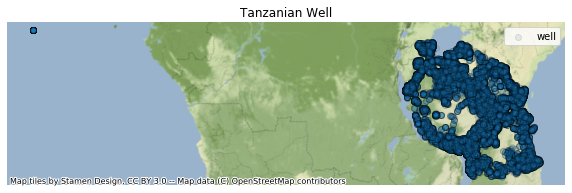

In [32]:
# create geopandas frames
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

gdf = gdf.to_crs(epsg=3857)

# map the features using their geo coordinates
all_wells = gdf.plot(figsize=(10, 10), alpha=0.1, edgecolor='k', label='well')
plt.title('Tanzanian Well')
plt.legend()
ctx.add_basemap(all_wells, source=ctx.providers.Stamen.TerrainBackground)
all_wells.set_axis_off()

WOW outliers. Some of the columns have missing coordinates.

In [45]:
gdf = gdf[gdf['longitude'] != 0]

In [67]:
gdf['status_group'].value_counts()

functional                 31389
non functional             22268
functional needs repair     3931
Name: status_group, dtype: int64

In [68]:
functional_gdf = gdf[gdf['status_group'] == 'functional']
non_functional_gdf = gdf[gdf['status_group'] == 'non functional']
needs_repair_gdf = gdf[gdf['status_group'] == 'functional needs repair']

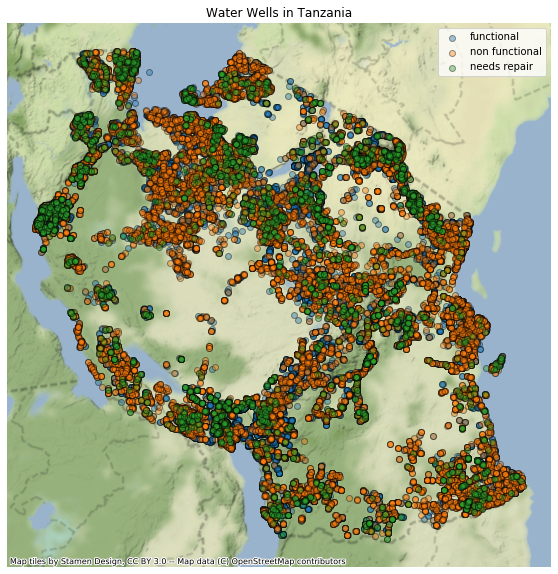

In [216]:
# map the features using their geo coordinates
wells_ax = functional_gdf.plot(figsize=(10, 10), alpha=0.4, edgecolor='k', label='functional')
wells_ax = non_functional_gdf.plot(ax=wells_ax, figsize=(10, 10), alpha=0.4, edgecolor='k', label='non functional')
wells_ax = needs_repair_gdf.plot(ax=wells_ax, figsize=(10, 10), alpha=0.4, edgecolor='k', label='needs repair')

plt.legend()
plt.title('Water Wells in Tanzania')
ctx.add_basemap(wells_ax, source=ctx.providers.Stamen.TerrainBackground)
wells_ax.set_axis_off()